<a href="https://colab.research.google.com/github/jdlg-42/TFG/blob/main/distancias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install igraph
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.4 MB/s eta 0:00:00


# Código para generar grafos de PSN

In [2]:
# Sitios importantes

sites = {
    "A2A_adenosine": [168, 169, 253, 277, 278],
    "A2A_G": [102, 110, 227, 231, 235],
    "beta2AR_epi1": [1113, 1114, 1117, 1193, 1203, 1207, 1289, 1290, 1293, 1312, 1316], # datos de PDB. El indexado de los sitios no coincide con la distribución real de los mismos.
    "beta2AR_epi2": [109, 110, 113, 114, 117, 192, 193, 203, 204, 207, 289, 290, 293, 308, 309, 312],
    "beta2AR_epi3": [262, 263, 266, 342, 352, 356, 410, 411, 414, 433, 437], # sitios de unión de ligandos con numeración real.
    "beta2AR_G": [131, 134, 135, 136, 138, 139, 142, 222, 226, 229, 233, 236, 239, 271, 274] # solo tomamos los valores superiores a 0.5 (en PDB se recogen los valores).
    }

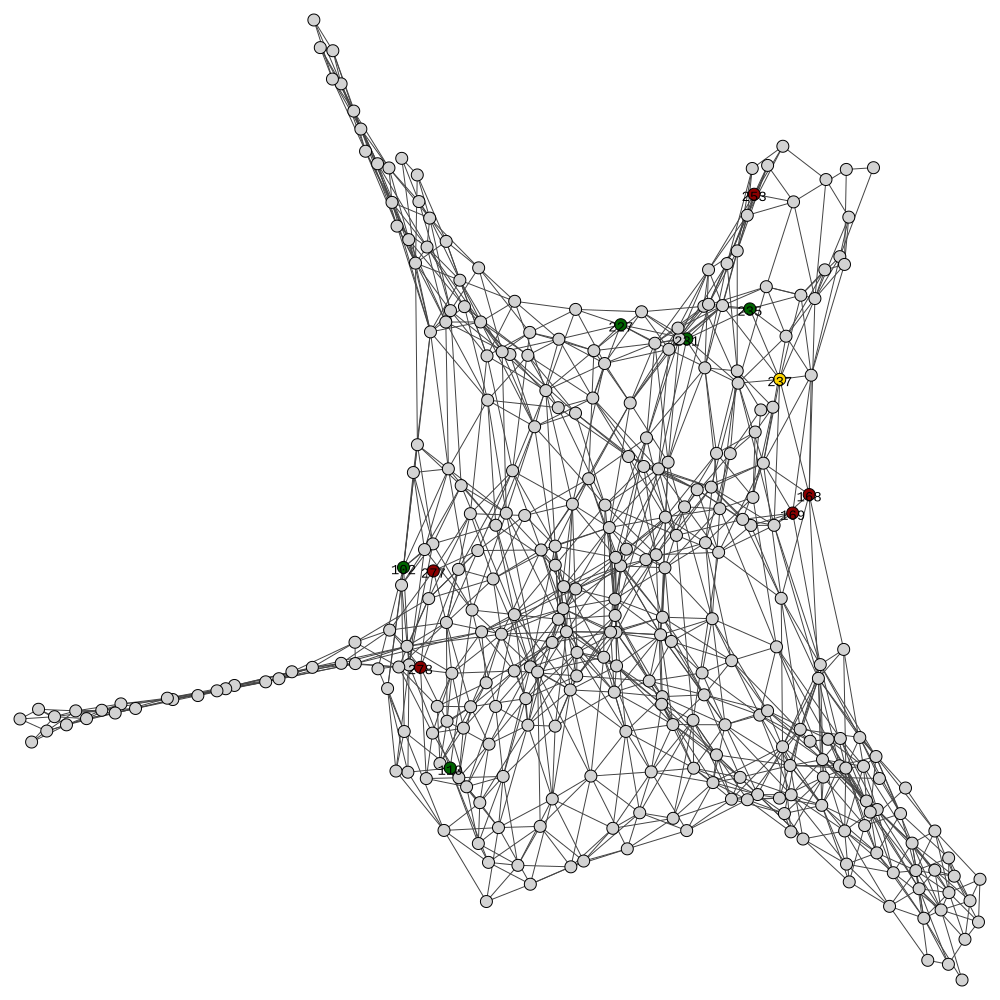

In [ ]:
## Representación grafo de proteínas ##

'''
Este bloque de código extrae los aminoácidos del archivo PDB asignado y genera
una matriz de adyacencia para luego graficar en forma de PSN la proteína,
analizando los residuos que forman parte de los sitios alostérico y ortostérico

Entrada: un archivo .pdb
Salida: matriz de adyacencia y grafo de estructura de proteínas
'''

# == Comandos de preparación ==

# Importar librerías
from Bio.PDB import PDBParser
from scipy.spatial import cKDTree
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt

# Establecer semillas para la reproducibilidad del grafo
np.random.seed(42)
random.seed(42)

pdb_id = "2ydo"
parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}.pdb")

# Extracción de los CA en una lista

CA_coord = []
for model in structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                if atom.get_name() == "CA":
                   CA_coord.append(atom.get_coord())

# Extracción de las coordenadas de átomos del ligando

alig_list = []
alig_coord = []

# for model in structure:
#     for chain in model:
#         if chain.id != "A":
#             continue
#         for residue in chain:
#             if residue.get_resname() == "ADN" and residue.id[1] == 400:
#                 for atom in residue:
#                     alig_list.append(atom.get_id())
#                     alig_coord.append(atom.get_coord())
                    # print(residue.get_resname(), residue.id) # debug print

# Generamos un conjunto con los elementos de alig_coord y de CA_coord

atom_coord = []
for acoord in CA_coord:
  atom_coord.append(acoord)
for acoord in alig_coord:
  atom_coord.append(acoord)

# Generación del árbol (cKDTree) y generación de pares de átomos

tree = cKDTree(atom_coord)
atom_pairs = tree.query_pairs(r=10) # permite regular el radio de la esfera
# de distancia

r_min = 4
r_max = 8

# Filtrar solo los que están entre r_min y r_max
atom_pairsfilt = set()
for i, j in atom_pairs:
    dist = np.linalg.norm(atom_coord[i] - atom_coord[j])
    if r_min <= dist <= r_max:
        atom_pairsfilt.add((i, j))


# Cálculo de los caminos más cortos (shortest pathways)

shortest_path = None
min_len = float('inf')

for a in sites["A2A_adenosine"]:
    for o in sites["A2A_G"]:
        try:
            path = g.get_shortest_paths(a, to=o)[0]
            if path and len(path) < min_len:
                shortest_path = path
                min_len = len(path)
        except:
            continue

# Generación del grafo

g = ig.Graph()
g.add_vertices(len(atom_coord))
for i, j in atom_pairsfilt:
    g.add_edge(i, j)

g.vs["size"] = 12
g.vs["color"] = ["lightgray"]

# === Cálculo de caminos más cortos ===
shortest_path = None
min_len = float('inf')

for a in sites["A2A_adenosine"]:
    for o in sites["A2A_G"]:
        try:
            path = g.get_shortest_paths(a, to=o)[0]
            if path and len(path) < min_len:
                shortest_path = path
                min_len = len(path)
        except:
            continue

if shortest_path:
    for node in shortest_path:
        g.vs[node]["color"] = "gold"
        g.vs[node]["label"] = str(node)

# Colorear los nodos de los sitios de interés
for aa in sites["A2A_adenosine"]:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkred"
        g.vs[aa]["label"] = aa

for aa in sites["A2A_G"]:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkgreen"
        g.vs[aa]["label"] = aa

# Colorear los nodos del ligando en azul oscuro
lig_start_idx = len(CA_coord)
lig_end_idx = lig_start_idx + len(alig_coord)

for i in range(lig_start_idx, lig_end_idx):
    g.vs[i]["color"] = "navy"
    g.vs[i]["label"] = alig_list[i - lig_start_idx]  # Opcional, puede ser atom ID




layout = g.layout_fruchterman_reingold()
ig.plot(g, layout=layout, bbox=(1000, 1000))


# site_nodes = sites["A2A_adenosine"] + sites["A2A_G"]
# subg = g.subgraph(site_nodes)
# ig.plot(subg)

Caminos más cortos entre los nodos (168, 235) (color: orange):
  Nodos involucrados: [168, 237, 235]
  Longitud del camino: 3
  Color asignado: orange
Caminos más cortos entre los nodos (168, 231) (color: purple):
  Nodos involucrados: [168, 171, 234, 231]
  Longitud del camino: 4
  Color asignado: purple
Caminos más cortos entre los nodos (169, 231) (color: green):
  Nodos involucrados: [169, 171, 234, 231]
  Longitud del camino: 4
  Color asignado: green
Caminos más cortos entre los nodos (169, 235) (color: purple):
  Nodos involucrados: [169, 171, 237, 235]
  Longitud del camino: 4
  Color asignado: purple
Caminos más cortos entre los nodos (253, 227) (color: gold):
  Nodos involucrados: [253, 257, 229, 227]
  Longitud del camino: 4
  Color asignado: gold
Caminos más cortos entre los nodos (253, 231) (color: blue):
  Nodos involucrados: [253, 257, 229, 231]
  Longitud del camino: 4
  Color asignado: blue
Caminos más cortos entre los nodos (253, 235) (color: green):
  Nodos involucra

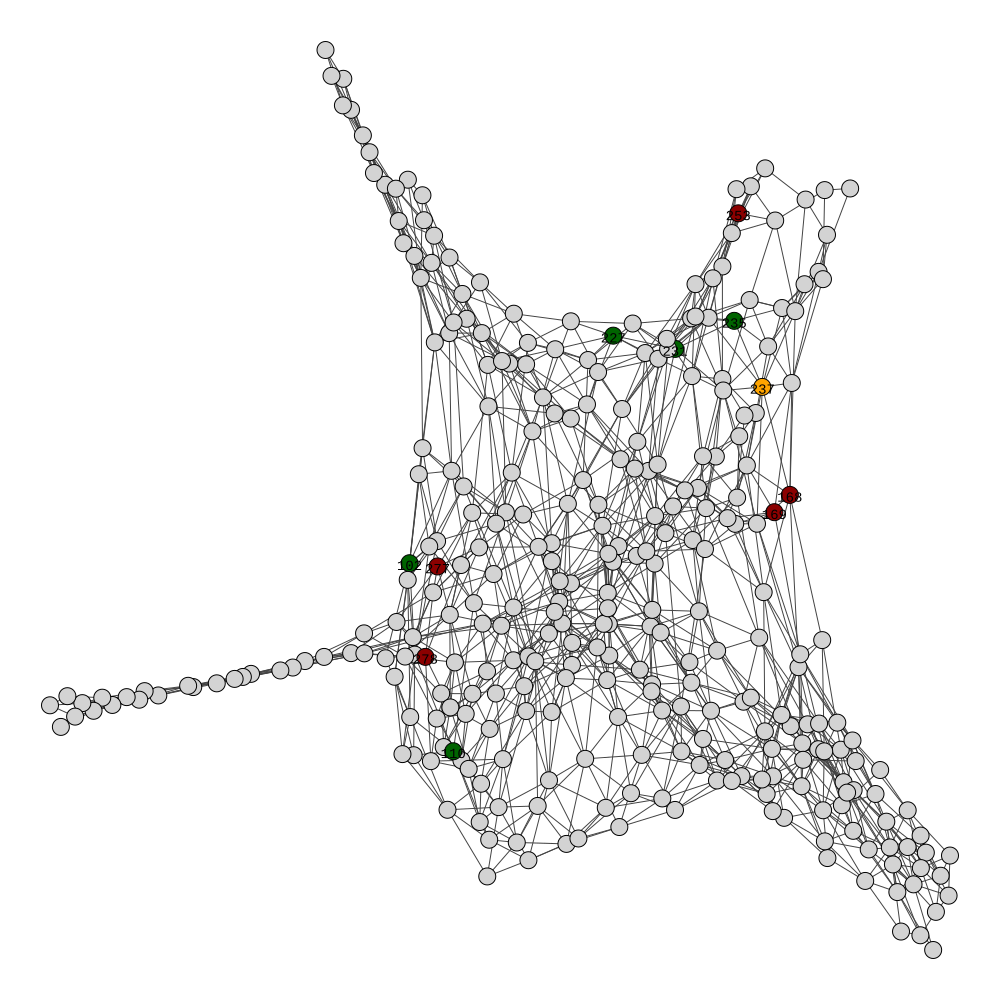

In [6]:
# == Comandos de preparación ==

from Bio.PDB import PDBParser
from scipy.spatial import cKDTree
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt
from IPython.display import display, HTML

np.random.seed(42)
random.seed(42)

pdb_id = "2ydo"
parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}.pdb")

# === Extracción de los CA ===
CA_coord = []
for model in structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                if atom.get_name() == "CA":
                   CA_coord.append(atom.get_coord())

# === (Opcional) Extracción del ligando ===
alig_list = []
alig_coord = []

# if deseas incluir ligando, descomenta esta sección
# for model in structure:
#     for chain in model:
#         if chain.id != "A":
#             continue
#         for residue in chain:
#             if residue.get_resname() == "ADN" and residue.id[1] == 400:
#                 for atom in residue:
#                     alig_list.append(atom.get_id())
#                     alig_coord.append(atom.get_coord())

atom_coord = CA_coord + alig_coord

# === Árbol de búsqueda y pares ===
tree = cKDTree(atom_coord)
atom_pairs = tree.query_pairs(r=10)

r_min = 4
r_max = 8
atom_pairsfilt = set()
for i, j in atom_pairs:
    dist = np.linalg.norm(atom_coord[i] - atom_coord[j])
    if r_min <= dist <= r_max:
        atom_pairsfilt.add((i, j))

# === Cálculo de caminos más cortos ===
shortest_paths = []  # Lista para almacenar todos los caminos más cortos y sus colores
colors = ["gold", "blue", "green", "purple", "orange", "cyan"]  # Lista de colores que se asignarán a los caminos

# Cálculo de los caminos más cortos
for a in sites["A2A_adenosine"]:
    for o in sites["A2A_G"]:
        try:
            path = g.get_shortest_paths(a, to=o)[0]
            if path:
                shortest_paths.append({
                    "path": path,
                    "length": len(path),
                    "color": colors[len(shortest_paths) % len(colors)],  # Asignar un color por cada camino
                    "nodes": (a, o)
                })
        except:
            continue

# === Grafo ===
g = ig.Graph()
g.add_vertices(len(atom_coord))
for i, j in atom_pairsfilt:
    g.add_edge(i, j)

g.vs["size"] = 17
g.vs["color"] = ["lightgray"]
g.vs["label"] = [None] * len(g.vs)

# === Ligando ===
lig_start_idx = len(CA_coord)
lig_end_idx = lig_start_idx + len(alig_coord)
for i in range(lig_start_idx, lig_end_idx):
    g.vs[i]["color"] = "navy"
    g.vs[i]["label"] = alig_list[i - lig_start_idx]

shortest_paths.sort(key=lambda x: x["length"])

# === Asignación de colores a los caminos más cortos ===
for idx, path_info in enumerate(shortest_paths):
    color = path_info["color"]
    path = path_info["path"]
    # Imprimir la información de cada shortest path
    print(f"Caminos más cortos entre los nodos {path_info['nodes']} (color: {color}):")
    print(f"  Nodos involucrados: {path}")
    print(f"  Longitud del camino: {path_info['length']}")
    print(f"  Color asignado: {color}")
    print("="*50)

# === Preguntar al usuario qué camino desea visualizar ===
try:
    selection = int(input("Introduce el número del camino más corto que deseas visualizar (0 para no representar ninguno): "))
    if 1 <= selection <= len(shortest_paths):
        chosen_path = shortest_paths[selection - 1]
        path = chosen_path["path"]
        color = chosen_path["color"]

        for node in path:
            g.vs[node]["color"] = color
            g.vs[node]["label"] = str(node)
    else:
        print("Número fuera de rango. No se coloreará ningún camino.")
except ValueError:
    print("Entrada no válida. No se coloreará ningún camino.")


# === Sitios de interés (debes definir previamente el diccionario 'sites') ===
for aa in sites["A2A_adenosine"]:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkred"
        g.vs[aa]["label"] = str(aa)

for aa in sites["A2A_G"]:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkgreen"
        g.vs[aa]["label"] = str(aa)

# === Plot ===
layout = g.layout_fruchterman_reingold()
ig.plot(g, layout=layout, bbox=(1000, 1000), margin=50)

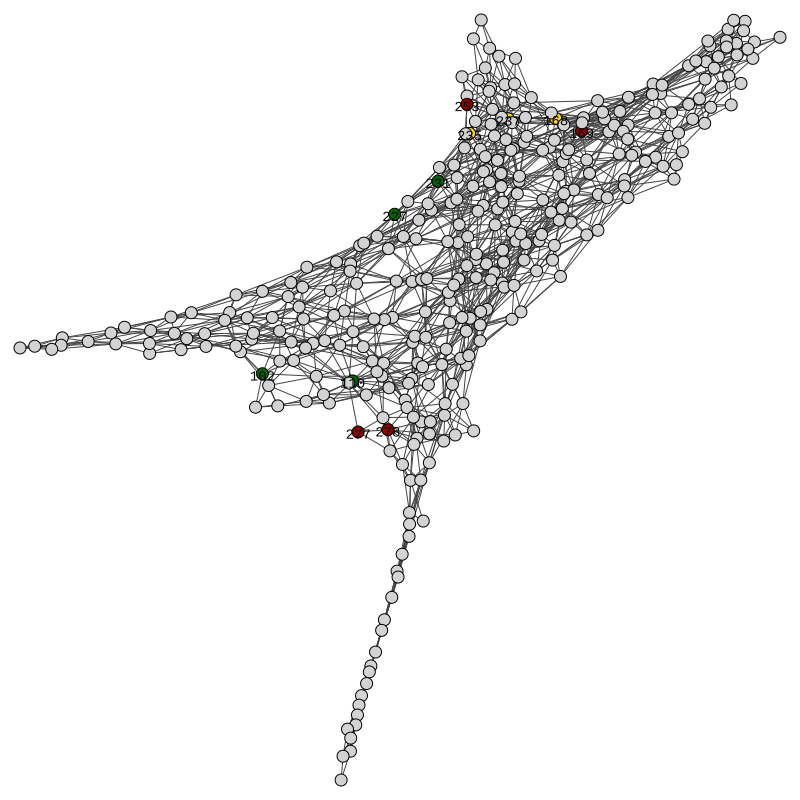

In [ ]:
## Representación grafo de proteínas ##

'''
Este bloque de código extrae los aminoácidos del archivo PDB asignado y genera
una matriz de adyacencia para luego graficar en forma de PSN la proteína,
analizando los residuos que forman parte de los sitios alostérico y ortostérico

Entrada: un archivo .pdb
Salida: matriz de adyacencia y grafo de estructura de proteínas
'''

# == Comandos de preparación ==

# Importar librerías
from Bio.PDB import PDBParser
from scipy.spatial import cKDTree
import numpy as np
import random
import igraph as ig
import matplotlib.pyplot as plt

# Establecer semillas para la reproducibilidad del grafo
np.random.seed(42)
random.seed(42)

pdb_id = "2ydo"
parser = PDBParser(QUIET=True)
structure = parser.get_structure(f"{pdb_id}", f"pdb{pdb_id}.pdb")

# Extracción de los centroides de residuos en una lista

residue_centroids = []
for model in structure:
    for chain in model:
        for residue in chain:
            # atom_coords = [atom.get_coord() for atom in residue if atom.get_id()[0] == " "]  # Solo átomos estándar # This line was causing the problem
            # The original line only considered coordinates for 'standard' atoms, which might not be present
            atom_coords = [atom.get_coord() for atom in residue] # Using all atom coords
            if atom_coords:
                centroid = np.mean(atom_coords, axis=0)
                residue_centroids.append(centroid)

# CA_coord = []  # ← Reemplazado por centroides
# for model in structure:
#     for chain in model:
#         for residue in chain:
#             for atom in residue:
#                 if atom.get_name() == "CA":
#                    CA_coord.append(atom.get_coord())

# Extracción de las coordenadas de átomos del ligando

alig_list = []
alig_coord = []

# for model in structure:
#     for chain in model:
#         if chain.id != "A":
#             continue
#         for residue in chain:
#             if residue.get_resname() == "ADN" and residue.id[1] == 400:
#                 for atom in residue:
#                     alig_list.append(atom.get_id())
#                     alig_coord.append(atom.get_coord())
                    # print(residue.get_resname(), residue.id) # debug print

# Generamos un conjunto con los elementos de alig_coord y de residue_centroids

atom_coord = []
for acoord in residue_centroids:
  atom_coord.append(acoord)
for acoord in alig_coord:
  atom_coord.append(acoord)

# Generación del árbol (cKDTree) y generación de pares de átomos

tree = cKDTree(atom_coord)
atom_pairs = tree.query_pairs(r=10) # permite regular el radio de la esfera
# de distancia

r_min = 4
r_max = 8

# Filtrar solo los que están entre r_min y r_max
atom_pairsfilt = set()
for i, j in atom_pairs:
    dist = np.linalg.norm(atom_coord[i] - atom_coord[j])
    if r_min <= dist <= r_max:
        atom_pairsfilt.add((i, j))

# Generación del grafo

g = ig.Graph()
g.add_vertices(len(atom_coord))
for i, j in atom_pairsfilt:
    g.add_edge(i, j)

g.vs["size"] = 12
g.vs["color"] = ["lightgray"]

# Colorear los nodos de los sitios de interés
for aa in sites["A2A_adenosine"]:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkred"
        g.vs[aa]["label"] = aa

for aa in sites["A2A_G"]:
    if 0 <= aa < len(g.vs):
        g.vs[aa]["color"] = "darkgreen"
        g.vs[aa]["label"] = aa

# Colorear los nodos del ligando en azul oscuro
lig_start_idx = len(residue_centroids)
lig_end_idx = lig_start_idx + len(alig_coord)

for i in range(lig_start_idx, lig_end_idx):
    g.vs[i]["color"] = "navy"
    g.vs[i]["label"] = alig_list[i - lig_start_idx]  # Opcional, puede ser atom ID

# === Cálculo de caminos más cortos ===
shortest_path = None
min_len = float('inf')

for a in sites["A2A_adenosine"]:
    for o in sites["A2A_G"]:
        try:
            path = g.get_shortest_paths(a, to=o)[0]
            if path and len(path) < min_len:
                shortest_path = path
                min_len = len(path)
        except:
            continue

if shortest_path:
    for node in shortest_path:
        g.vs[node]["color"] = "gold"
        g.vs[node]["label"] = str(node)

layout = g.layout_fruchterman_reingold()
ig.plot(g, layout=layout, bbox=(800, 800))